In [8]:
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 

from IS18 import utils
from IS18 import rectification
from IS18 import stereo
from IS18 import triangulation

from bundle_adjust import ba_utils

import s2p
import pickle
import rpcm
from PIL import Image

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
%matplotlib inline
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set experiment

In [9]:
#GLOBAL VARIABLES
ALL_PIPELINE = True
CHECK_TRIANGULATION_DISTANCE = True
SAVE_SIFT_CLOUDS = True
print('Global variables defined')

# select site and order of input pairs
site = 'IARPA' # IARPA, JAX_113, JAX_161, JAX_251
order = 'heuristic' # oracle, heuristic, sift

exp_name = site+'_ncc_alignment_'+order
input_dir = os.path.join('exp/',exp_name)
print('All files will be saved in "'+ input_dir + '"')
os.makedirs(input_dir, exist_ok=True)

Global variables defined
All files will be saved in "exp/IARPA_ncc_alignment_heuristic"


### Load data

Found 47 images
Number of images to be used: 47
Finished loading RPC coefficients
Finished cropping the AOI in each image



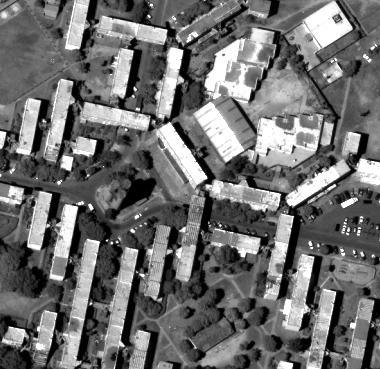
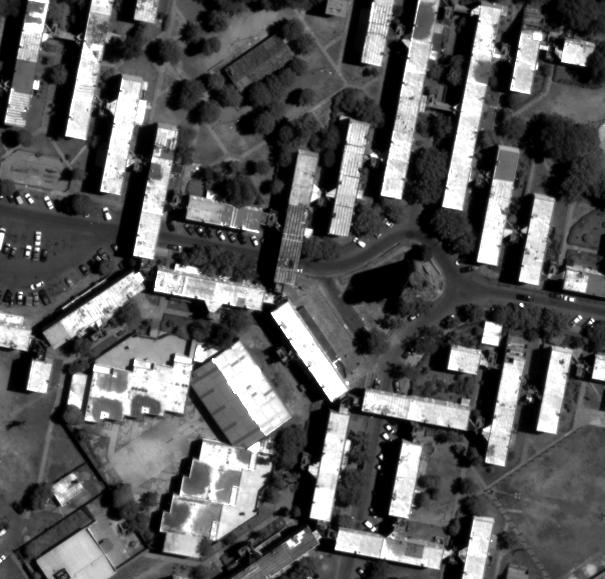
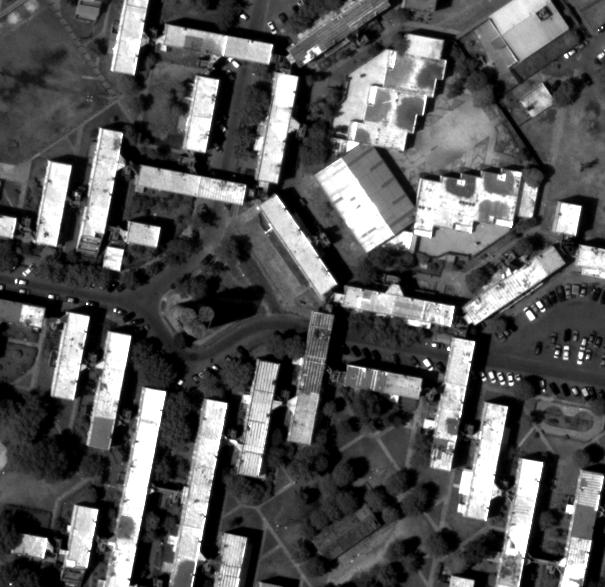
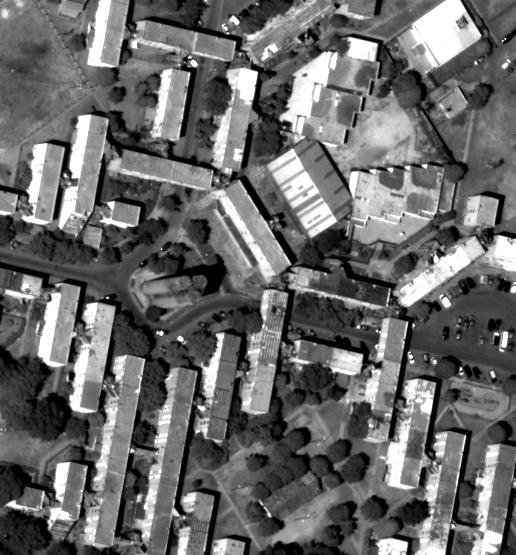
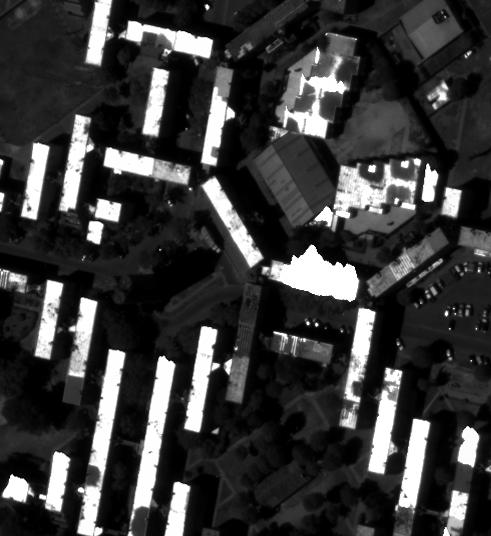
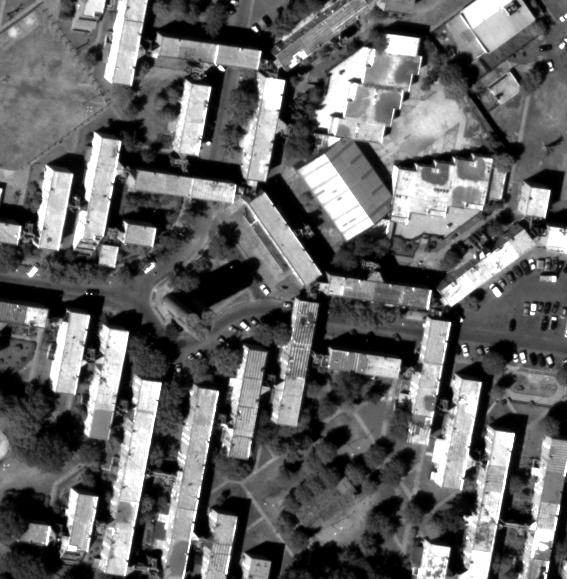
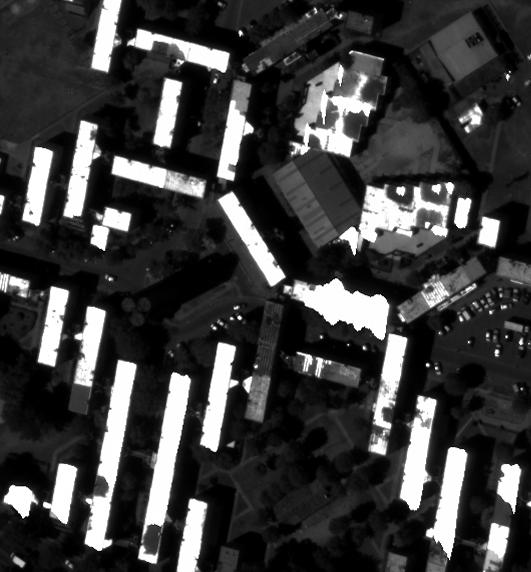
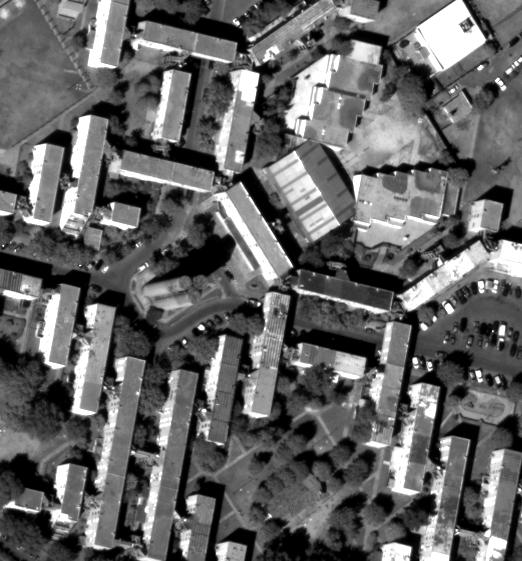
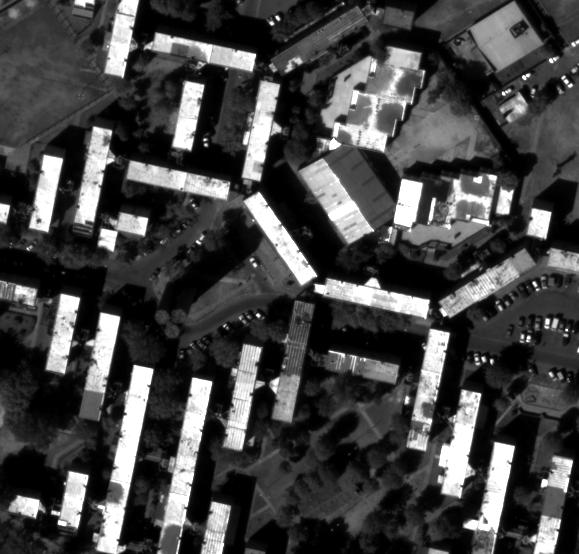
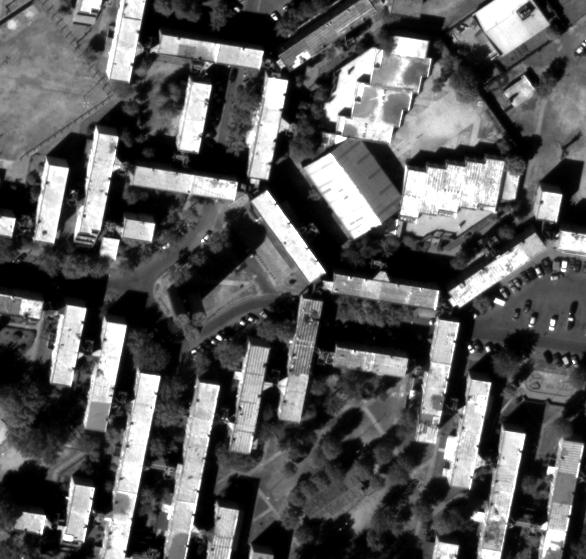
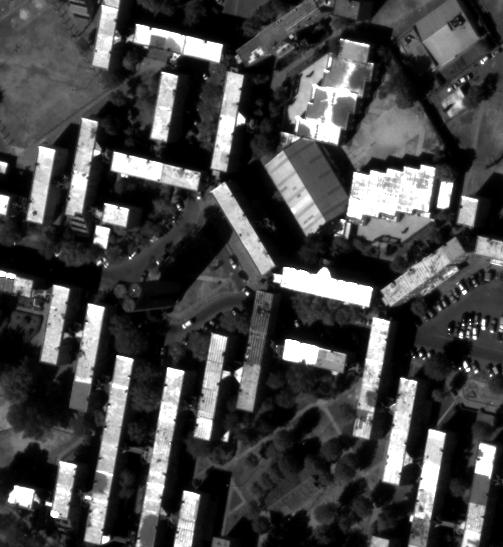
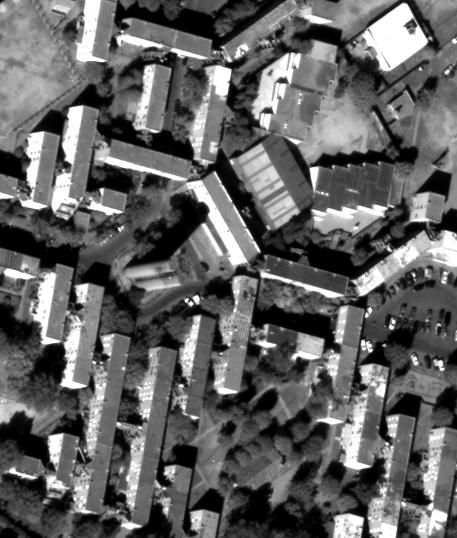
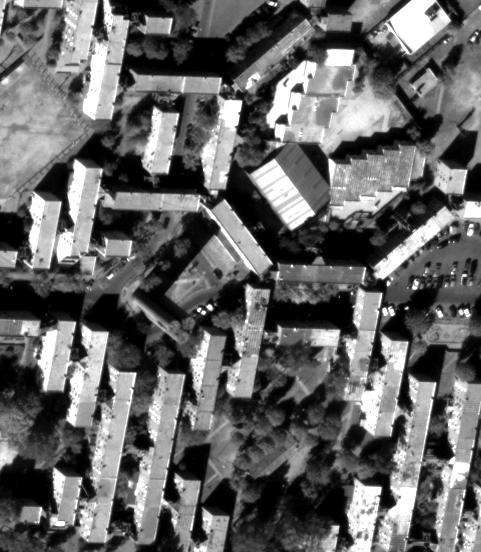
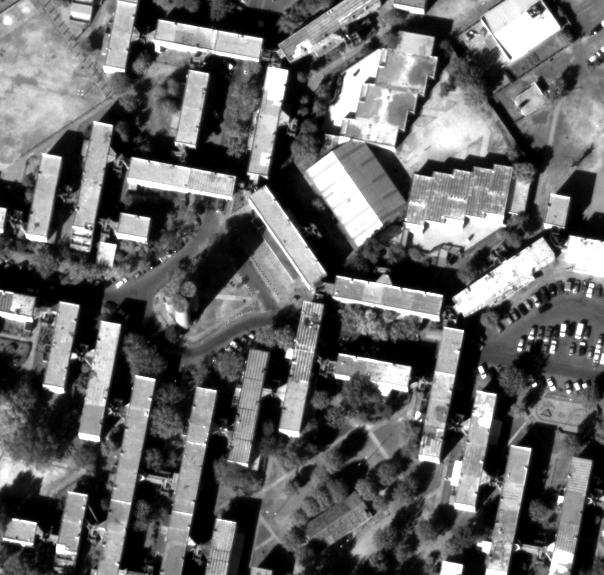
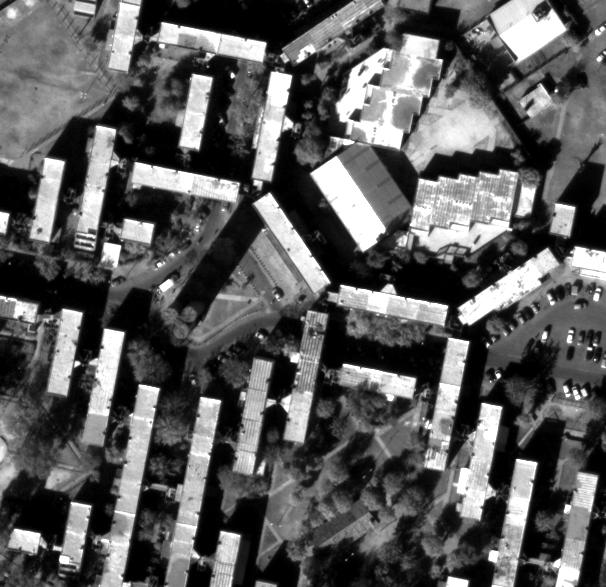
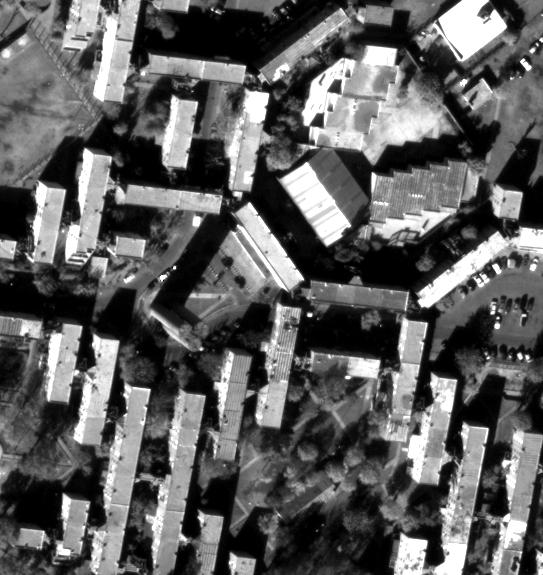
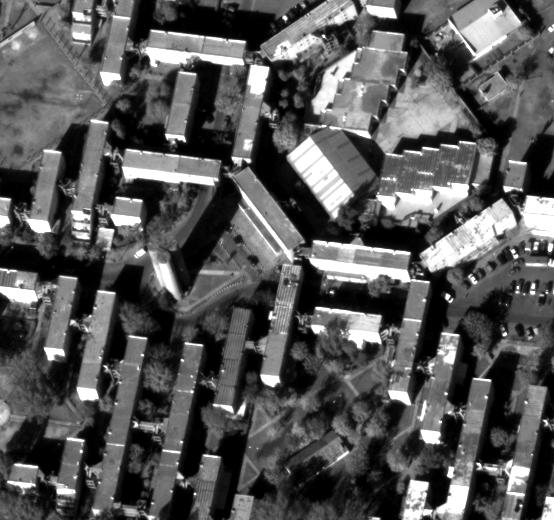
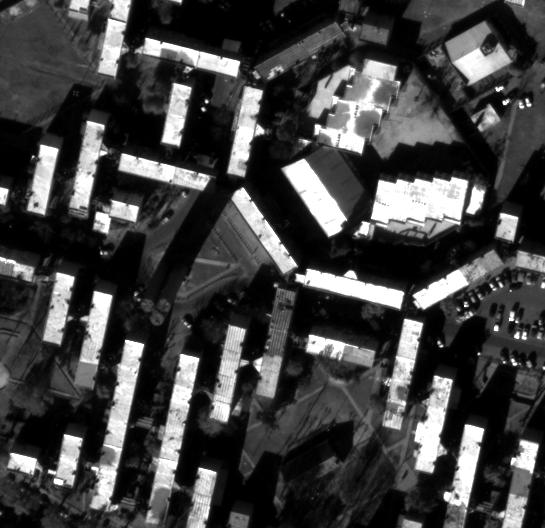
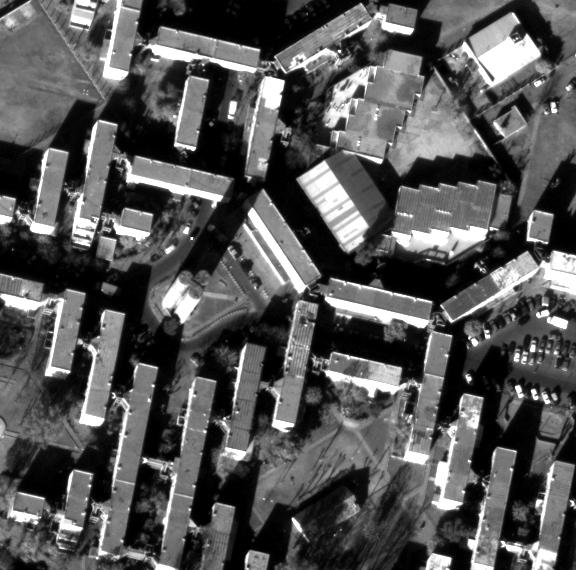
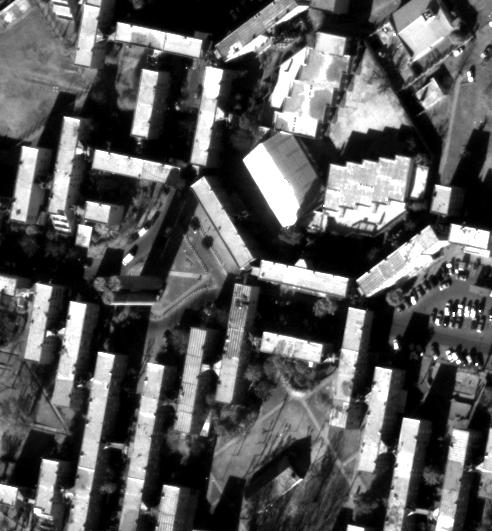
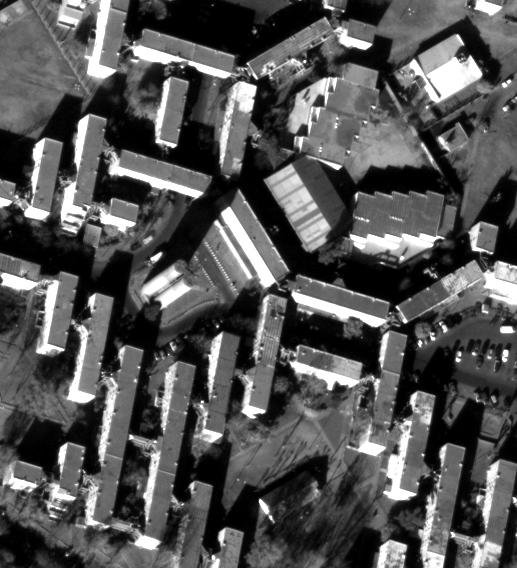
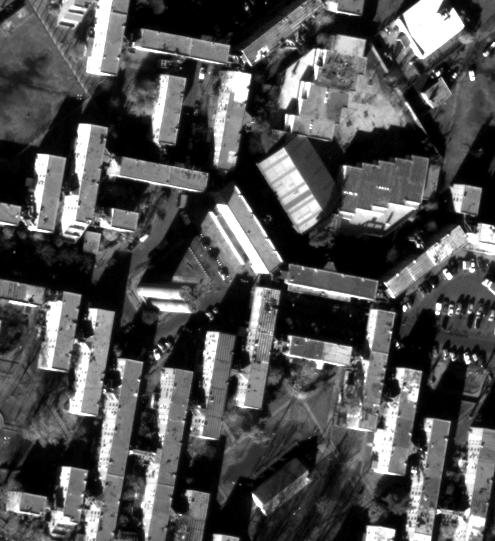
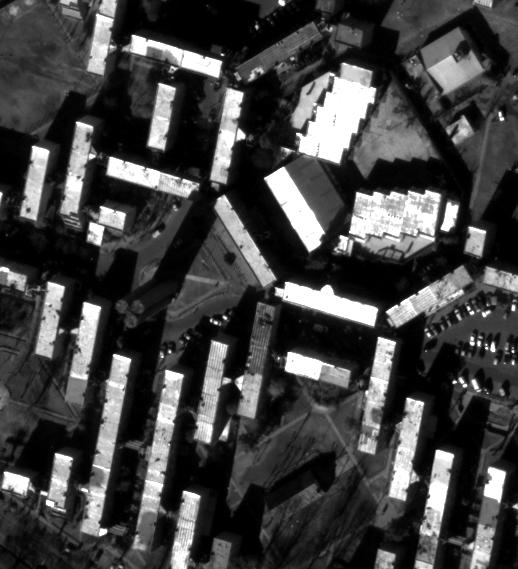
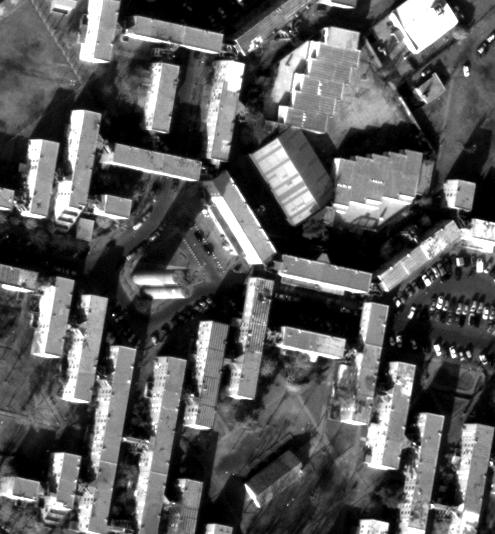
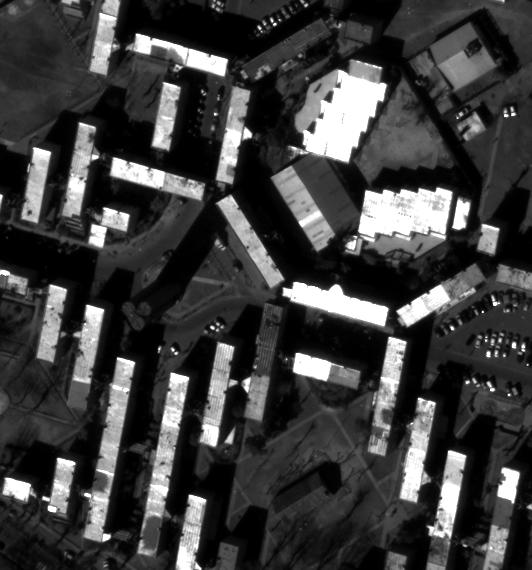
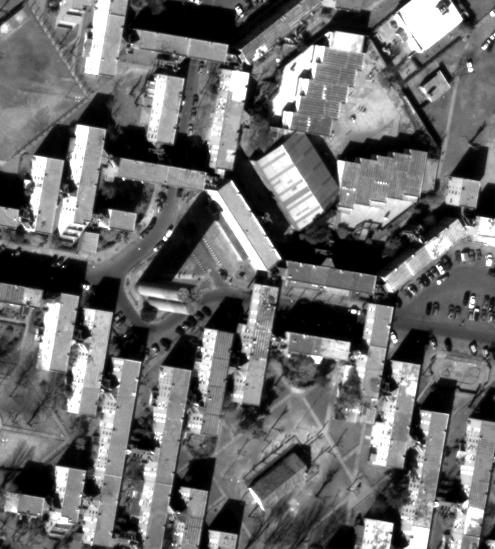
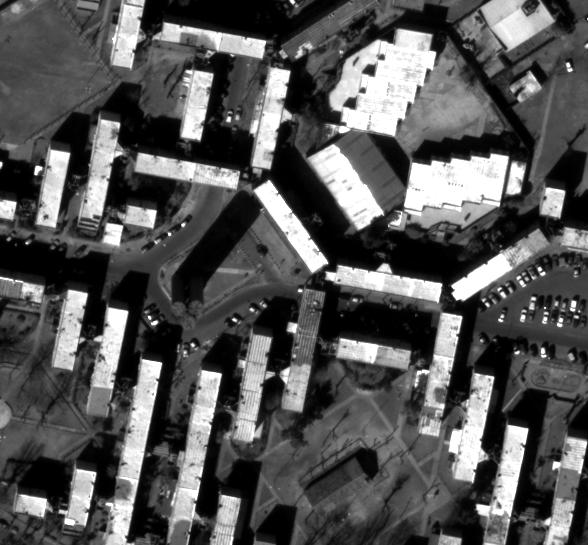
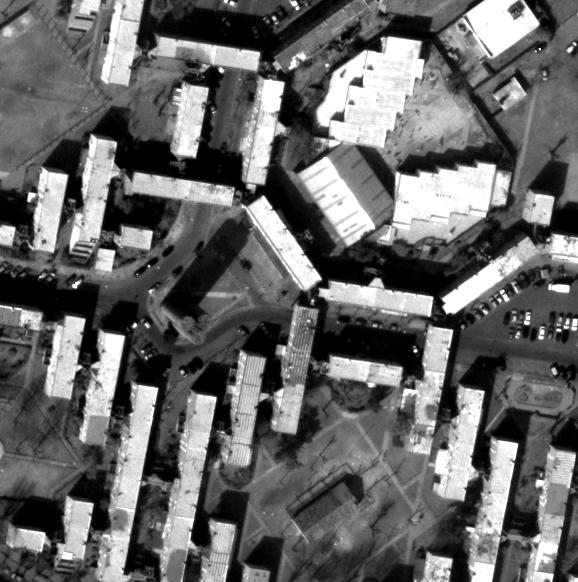
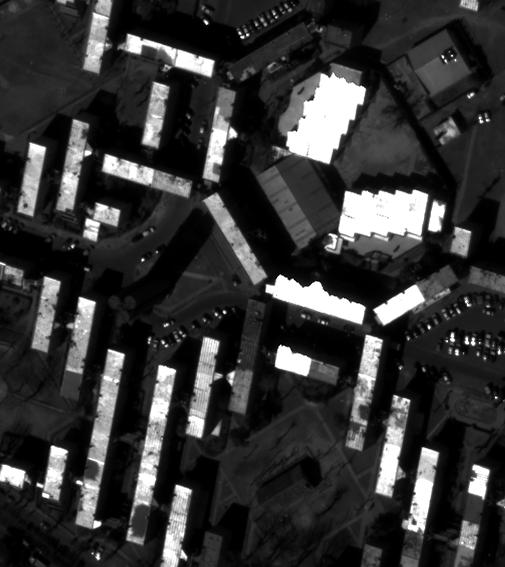
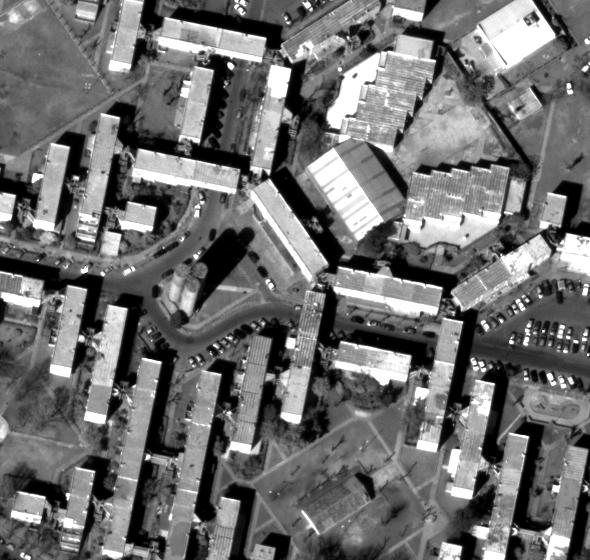
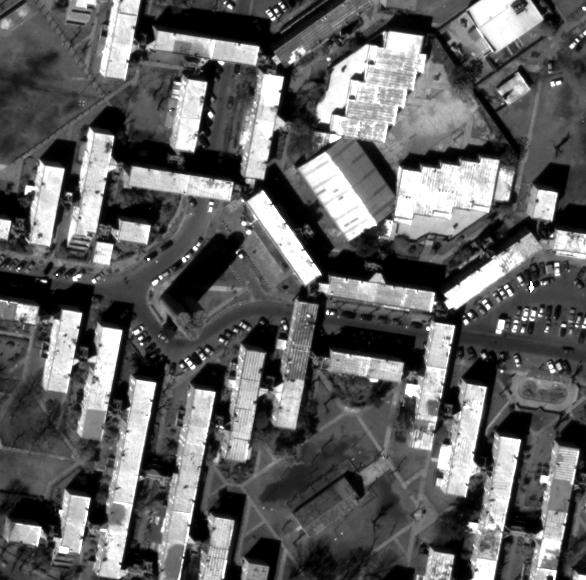
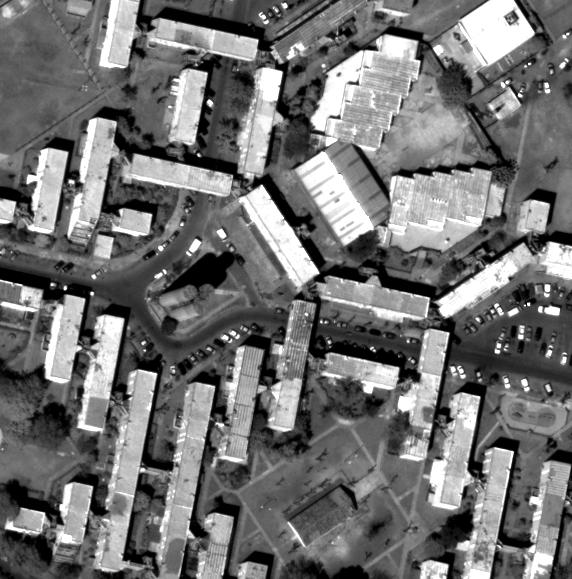
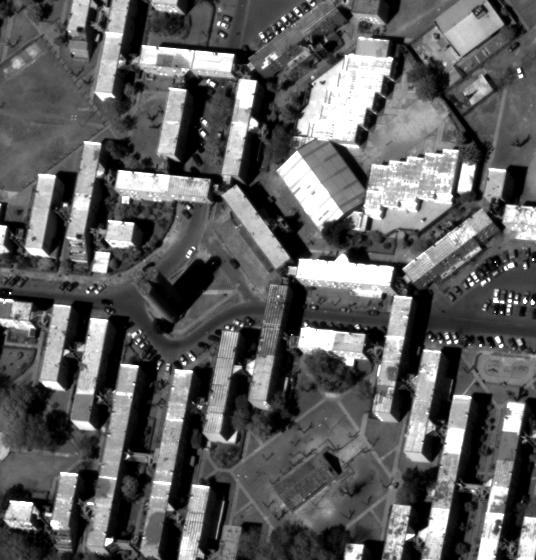
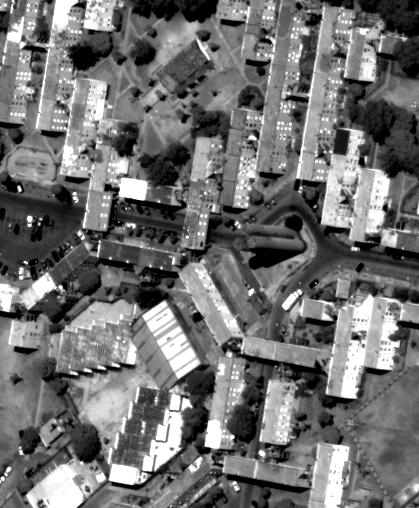
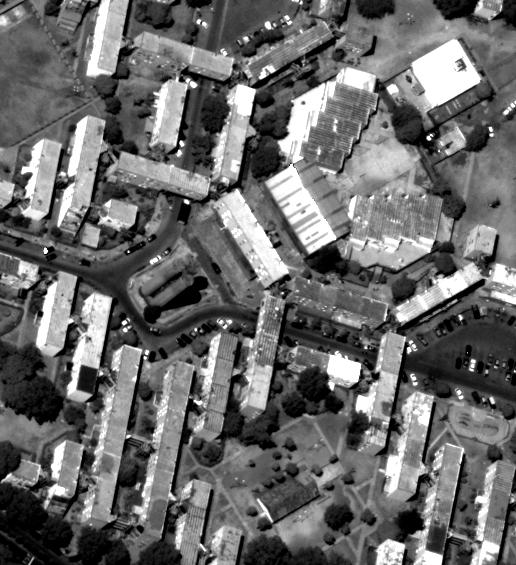
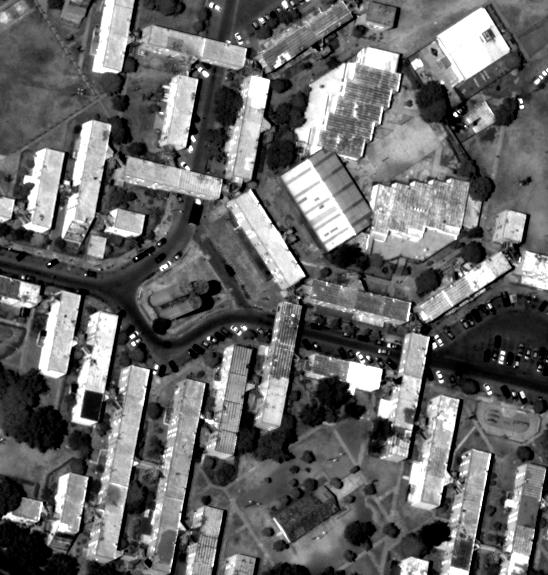
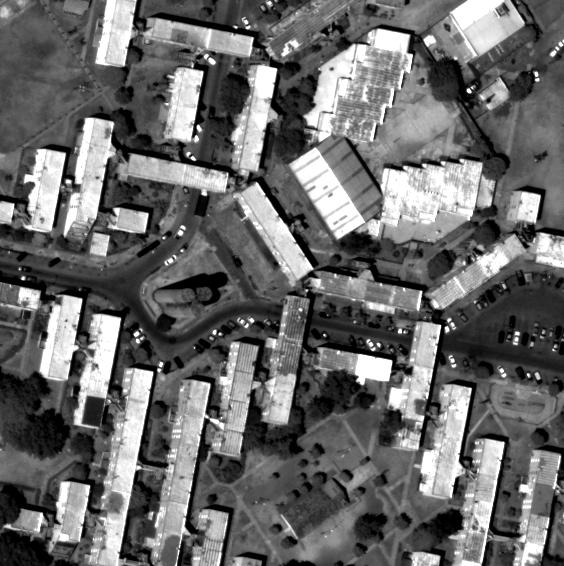
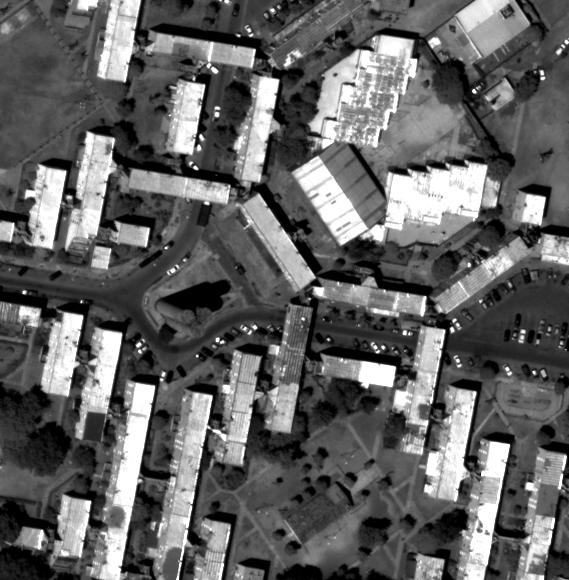
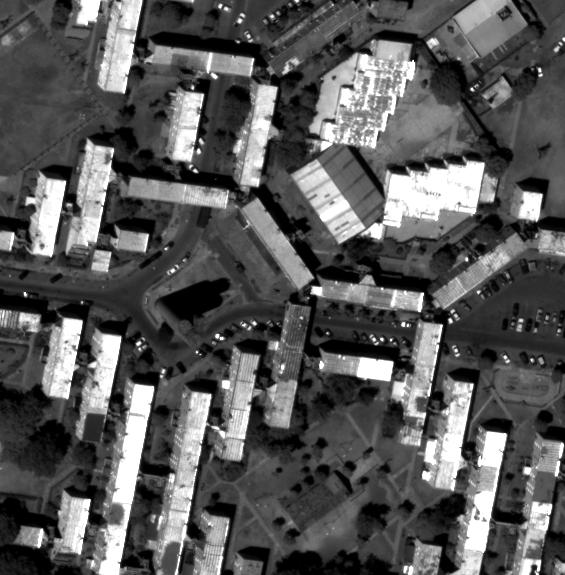
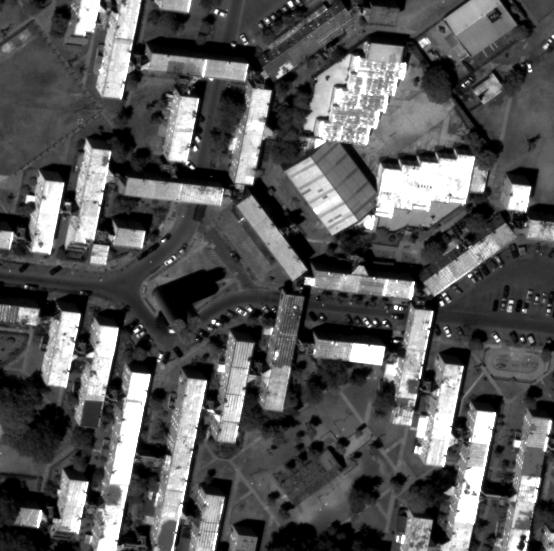
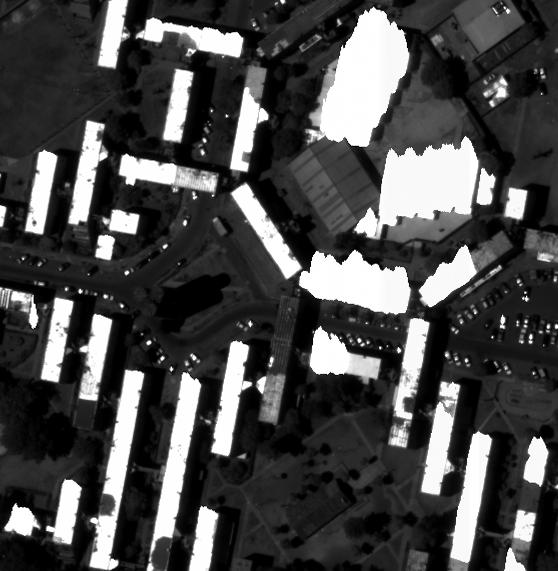
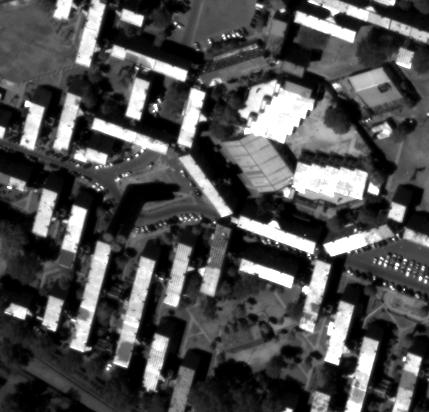
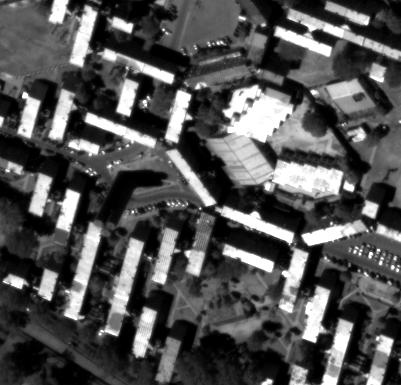
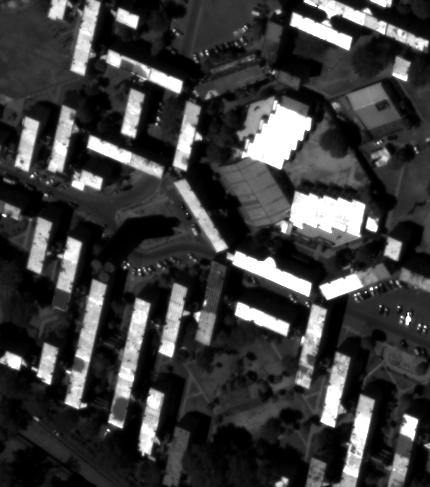
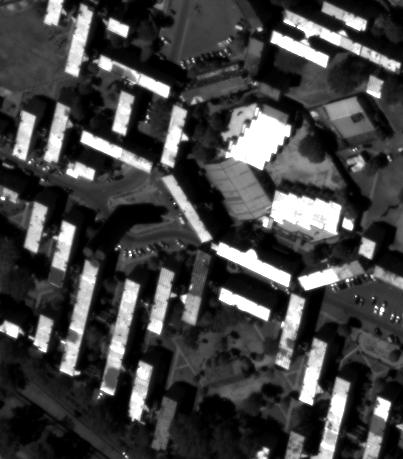
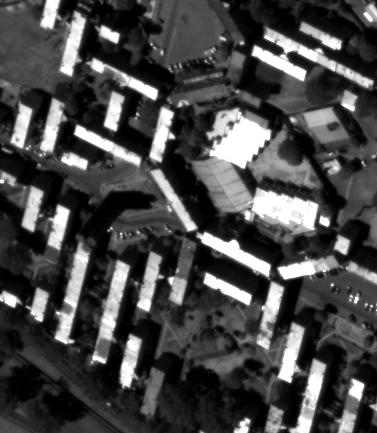
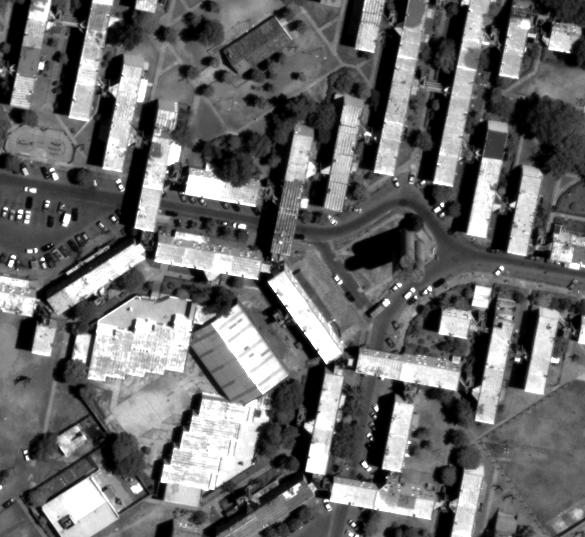

Crops were saved at data/ICCV19_IARPA


In [10]:
if site == 'IARPA':   
    # list the tiff images available in the remote folder
    IARPAurl = 'http://138.231.80.166:2332/iarpa-2016/cloud_optimized_geotif/'
    myimages = utils.listFD(IARPAurl, 'TIF')

    # sort the images by acquisition date
    myimages = sorted(myimages, key=utils.acquisition_date)
    myimages.pop(11)
    myimages.pop(13)
    myimages.pop(19)
    print('Found {} images'.format(len(myimages)))
    
    # set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
    aoi = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                            [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field
    
elif site in ['JAX_113', 'JAX_161', 'JAX_251']:   
    # list the tiff images available in the remote folder
    myimages = utils.listFD('http://138.231.80.166:2332/core3d/Jacksonville/WV3/PAN/', '.NTF.tif')

    # list the tiff images available in the remote folder
    mygts = utils.listFD('http://138.231.80.166:2332/grss-2019/track_3/Track3-Truth-geolocated/', '_DSM.tif')
    mygt_fn = [i for i in mygts if site in i]
    aoi = utils.get_image_longlat_polygon(mygt_fn[0])
    aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field
    
else: 
    print('input site is not valid!')
    
# select the number of cameras for the current run
n_cam = len(myimages)
print('Number of images to be used:', n_cam)

# load RPC coefficients
myrpcs = [utils.rpc_from_geotiff(x) for x in myimages]  ### ATTENTION! We use the old rpc model here
print('Finished loading RPC coefficients')              ### Else the old IS18 stuff risks to crash

# load image crops
mycrops = ba_utils.get_image_crops_from_aoi(myimages, aoi, display=True, \
                                            save_crops=True, output_dir='data/ICCV19_{}'.format(site))

### Compute point clouds for all pairs

In [11]:
import warnings
warnings.filterwarnings('ignore')

# get a dense point cloud for all possible pairs
list_of_pairs = ba_utils.get_predefined_pairs('pairs/'+site+'_'+order+'.txt', site, order, myimages)
os.makedirs(input_dir+'/clouds', exist_ok=True)
for iter_cont, pair in enumerate(list_of_pairs):
    idx_a, idx_b = pair
    print('Pocessing pair ({},{})...'.format(idx_a, idx_b))
    rect1, rect2, S1, S2, dmin, dmax, PA, PB = rectification.rectify_aoi(myimages[idx_a], myimages[idx_b], aoi)
    LRS, _, _ = stereo.compute_disparity_map(rect1, rect2, dmin-50, dmax+50 , cost='census')
    xyz = triangulation.triangulate_disparities(LRS, myrpcs[idx_a], myrpcs[idx_b], S1, S2, PA, PB)
    ba_utils.write_point_cloud_ply(input_dir+'/clouds/dense_cloud_{:02}_{:02}.ply'.format(idx_a, idx_b), xyz)
    print('{} / {} done'.format(iter_cont+1, len(list_of_pairs)))
print('Done!\n')

Pocessing pair (38,39)...
t=1.8689 done building CV
t=4.5030 done sgmfilter
t=4.6396 done aggregation and WTA refinement
t=1.8665 done building CV
t=4.4943 done sgmfilter
t=4.6305 done aggregation and WTA refinement
1 / 50 done
Pocessing pair (37,36)...
t=1.9406 done building CV
t=4.6647 done sgmfilter
t=4.8086 done aggregation and WTA refinement
t=1.9220 done building CV
t=5.0131 done sgmfilter
t=5.1727 done aggregation and WTA refinement
2 / 50 done
Pocessing pair (37,38)...
t=1.9621 done building CV
t=4.4794 done sgmfilter
t=4.6221 done aggregation and WTA refinement
t=1.9295 done building CV
t=4.6067 done sgmfilter
t=4.7494 done aggregation and WTA refinement
3 / 50 done
Pocessing pair (36,35)...
t=1.9130 done building CV
t=4.3794 done sgmfilter
t=4.5182 done aggregation and WTA refinement
t=1.9126 done building CV
t=4.9231 done sgmfilter
t=5.0808 done aggregation and WTA refinement
4 / 50 done
Pocessing pair (35,34)...
t=1.7309 done building CV
t=4.3565 done sgmfilter
t=4.4846 don

t=5.5519 done sgmfilter
t=5.7109 done aggregation and WTA refinement
36 / 50 done
Pocessing pair (20,21)...
t=2.5373 done building CV
t=5.6422 done sgmfilter
t=5.7891 done aggregation and WTA refinement
t=2.3942 done building CV
t=5.3243 done sgmfilter
t=5.4708 done aggregation and WTA refinement
37 / 50 done
Pocessing pair (6,4)...
t=2.9606 done building CV
t=7.0466 done sgmfilter
t=7.2658 done aggregation and WTA refinement
t=3.3362 done building CV
t=6.8882 done sgmfilter
t=7.1097 done aggregation and WTA refinement
38 / 50 done
Pocessing pair (2,1)...
t=3.2858 done building CV
t=7.5311 done sgmfilter
t=7.7443 done aggregation and WTA refinement
t=3.2850 done building CV
t=6.9816 done sgmfilter
t=7.2089 done aggregation and WTA refinement
39 / 50 done
Pocessing pair (34,33)...
t=2.7611 done building CV
t=5.8301 done sgmfilter
t=5.9951 done aggregation and WTA refinement
t=2.7411 done building CV
t=6.2273 done sgmfilter
t=6.3945 done aggregation and WTA refinement
40 / 50 done
Pocess